In [177]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [178]:
df = pd.read_csv('loan_data.csv')
df

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


Some basic visualizations to understand the kind of data we're looking at. Let's try and examine some basic correlations between things like the interest rates of the loans and FICO credit scores, as on average, we would assume a higher credit score = a lower interest rate

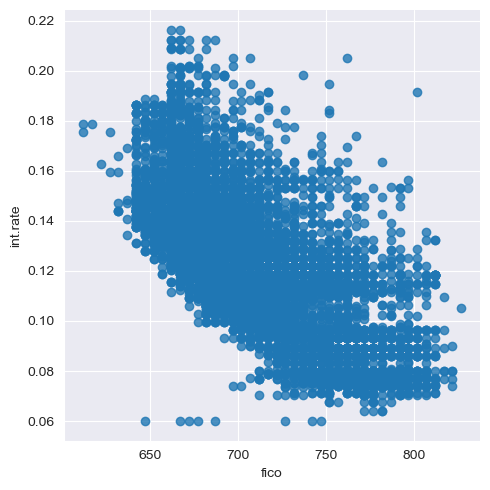

In [179]:
sns.set_style('darkgrid')
sns.lmplot(x="fico", y="int.rate", data=df, fit_reg=False)

Like expected, a general trend between higher credit scores and lower interest rates, but it is definitely not perfect. Let's include other features to see if we can create a better regression model.

<Axes: >

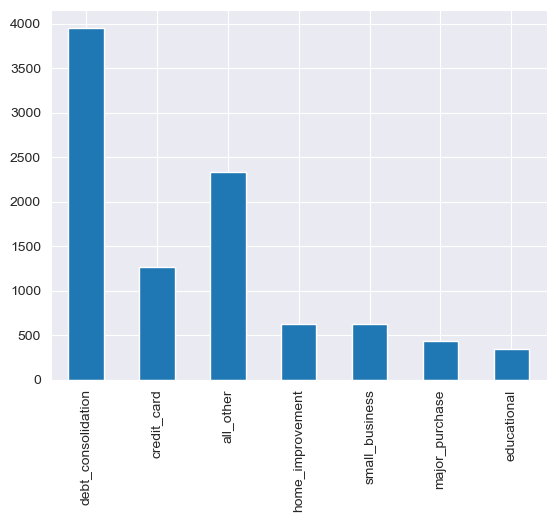

In [180]:
df['purpose'].value_counts(sort=False).plot.bar()

<Axes: >

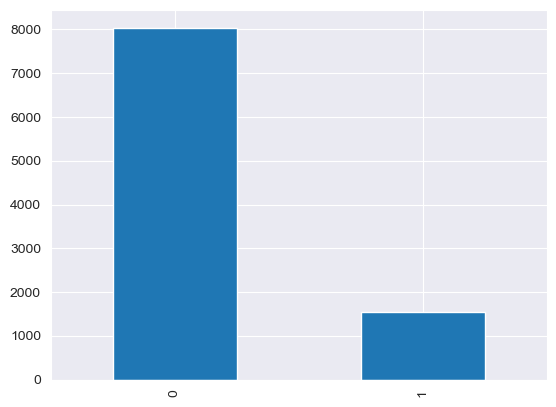

In [181]:
df['not.fully.paid'].value_counts(sort=False).plot.bar()

There are a lot more fully paid loans in this dataset than there are not fully paid loans. We need to keep this in mind when evaluating results for the model, but on average, we'll probably expect this model to be better at predicting fully-paid loans than not. We'll revisit this when distributing our training/testing data split.

Quick feature selection to see if there are any irrelevant features we can remove from the dataset

In [182]:
y = df['not.fully.paid']
X = df.drop('not.fully.paid', axis=1)

purpose_encoder = LabelEncoder()
X['purpose'] = purpose_encoder.fit_transform(X['purpose'])
X

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
0,1,2,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0
1,1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0
2,1,2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0
3,1,2,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0
4,1,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0
9574,0,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0
9575,0,2,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0
9576,0,4,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0


In [183]:
# adding a row of constant ones
X_1 = sm.add_constant(X)

# fitting an Ordinary Least Squares model
model = sm.OLS(y, X_1).fit()
model.pvalues

# backward elimination
columns, removed_cols, p_max = list(X.columns), [], 1
while len(columns) > 0:
    X_1 = X[columns]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y, X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index = columns)
    p_max = max(p)
    if p_max < 0.05:
        break
    print(p.idxmax())
    removed_cols.append(p.idxmax())
    columns.remove(p.idxmax())
    
selected_features = columns
print(selected_features)
        

revol.util
days.with.cr.line
dti
delinq.2yrs
['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc', 'fico', 'revol.bal', 'inq.last.6mths', 'pub.rec']


So we can see that the features we removed were revolving **revolving line utitlization rate**, **number of days the borrower has had a credit line**, **debt-to-income ratio**, **number of 30+ days late payments**. We've got relevant features now to use for our model prediction, and estimate whether a borrower is likely to pay back their loan in full or not.

In [184]:
# data standardization
# X = X[columns]
# scale = StandardScaler()
# scaled_df = scale.fit_transform(X)
# scaled_df

In [185]:
X = X[selected_features]
# randomly splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=14)

In [186]:
# create and fit the logistic regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=14)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

<Axes: >

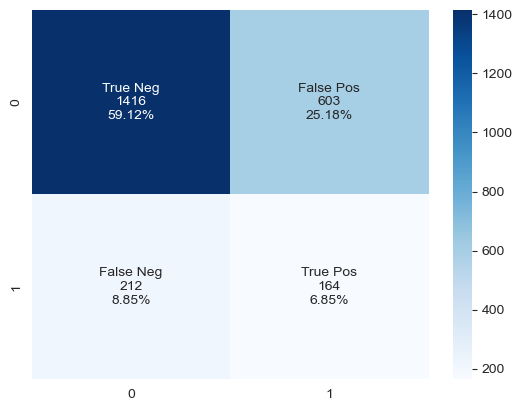

In [187]:
# evaluate model using confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cnf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cnf_matrix.flatten() / np.sum(cnf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')